In [11]:
import sys
sys.path.append("../")

import pandas as pd
import d2l
from mxnet import nd, gluon, autograd



In [12]:
'''
    Data pre-processing
'''
train_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')

print(train_data.shape)
print(test_data.shape)

print(train_data.iloc[:4, [0,1,2,3,-1]])

all_features = pd.concat((train_data.iloc[:, 1: -1], test_data.iloc[:, 1:]))

print(all_features.shape)


(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage  SalePrice
0   1          60       RL         65.0     208500
1   2          20       RL         80.0     181500
2   3          60       RL         68.0     223500
3   4          70       RL         60.0     140000
(2919, 79)


In [13]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x : (x - x.mean())/x.std()
)

all_features[numeric_features] = all_features[numeric_features].fillna(0)



In [14]:
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)


(2919, 331)


In [15]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[: n_train])
test_features = nd.array(all_features[n_train:])
train_labels = nd.array(train_data.SalePrice.values).reshape(shape=(-1,1))

fold 0, train rmse: 0.169632, valid rmse: 0.157057
fold 1, train rmse: 0.162248, valid rmse: 0.190244
fold 2, train rmse: 0.163803, valid rmse: 0.167908
fold 3, train rmse: 0.167663, valid rmse: 0.154692
fold 4, train rmse: 0.162656, valid rmse: 0.182807
5-fold validation: avg train rmse: 0.165201, avg valid rmse: 0.170542


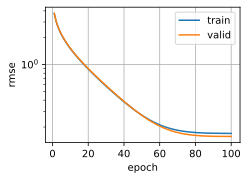

In [16]:

def get_net():
    net = gluon.nn.Sequential()
    net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

loss = gluon.loss.L2Loss()

def log_rmse(net, feature, labels):
    # To further stabilize the value when the logarithm is taken
    clipped_preds = nd.clip(net(feature), 1, float('inf'))
    rsme = nd.sqrt((loss(clipped_preds.log(), labels.log()) * 2).mean())
    return rsme.asscalar()

def get_data_iter(features, labels, batch_size, is_train=True):
    data_set = gluon.data.ArrayDataset(features, labels)
    data_iter = gluon.data.DataLoader(data_set, batch_size, shuffle=is_train)
    return data_iter

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_loss, test_loss = [], []
    train_data_loader = get_data_iter(train_features, train_labels, batch_size)
    trainer = gluon.Trainer(net.collect_params(), 'adam', 
                            {'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_data_loader:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_loss.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_loss.append(log_rmse(net, test_features, test_labels))
    return train_loss, test_loss


def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
                    X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k
        
    
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

Train rmse 0.162590


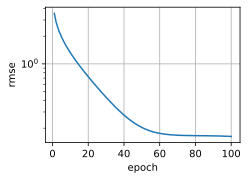

In [17]:
def train_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_loss, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(range(1, num_epochs+1), train_loss, xlabel='epoch', ylabel='rmse',
            yscale='log')
    print('Train rmse %f' % train_loss[-1])
    preds = net(test_features).asnumpy()
    
    test_data['SalePrice'] = pd.Series(preds.reshape((-1, 1)[0]))
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    
train_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

